<a href="https://colab.research.google.com/github/ShreyanshJoshi/Facial-Demographics-using-CNN/blob/master/Gender%20%26%20Age%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age & Gender Classifier using Deep CNNs  - 

**Dataset : UTKFace**

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

In this notebook, I have used the `aligned and cropped` faces available to train my models. Needless to say, any face input for testing must be cropped and aligned vertically to large extent

In [1]:
# Mounting the drive so that dataset can be loaded

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
dataset_folder_name = '/content/drive/My Drive/Images'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [ ]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be
# used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
# fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [ ]:

df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need 
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and 
# visualize data by plotting graphs.

,age,gender,race,file
0,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...
1,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170102...
2,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170102...
3,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170103...
4,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...


### Data analysis & visualization (EDA)

After some data preprocessing, let's analyze the data using graphs to get a  better understanding about its distribution





In [ ]:
df.info()       # No NAN values. Clean dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23708 entries, 0 to 23710
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23708 non-null  float64
 1   gender  23708 non-null  object 
 2   race    23708 non-null  object 
 3   file    23708 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.1+ KB


In [ ]:
df.describe()

# Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)

,age
count,23708.000000
mean,33.300363
std,19.884509
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


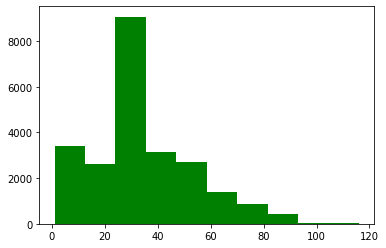

In [ ]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='green',histtype='bar')
plt.show()

# Majority population lies between 20-30 age group. Clearly, the dataset is not very well balanced. So training will 
# not be easy & accurate. We don't want to be biased. Try using class weights ?

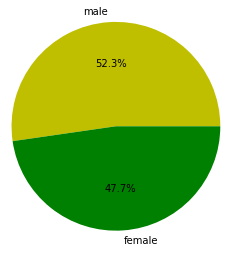

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
labels = ['male','female']
colors = [ 'y', 'g'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

# Uniform distribution to a large extent. Although, males slightly exceed females in numbers.No need to change gender in data. 
# Pretty well balanced ! Lets also visualize this on a bar graph (to get better understanding of numbers)

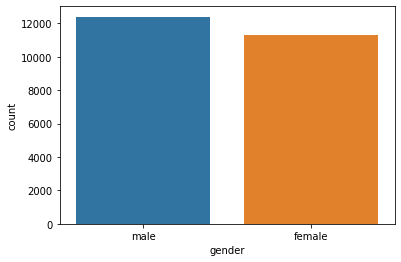

In [ ]:
sns.countplot(x='gender', data=df);

# Males ~ Just over 12k
# Females ~ Just over 11k

In [ ]:
df.groupby(['gender']).mean()             # Mean age by gender

,age
gender,
female,30.678186
male,35.694046


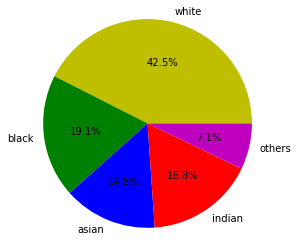

In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

gender = [x,y,z,a,b]
labels = ['white','black','asian','indian','others']
colors = [ 'y', 'g','b','r','m'] 
plt.pie(gender,labels = labels,colors = colors,radius=1.2,autopct='%.1f%%')
plt.show()

In [ ]:
df.groupby(['race']).mean()               # Mean age by race

,age
race,
asian,25.867501
black,33.860362
indian,31.532830
others,23.169031
white,37.978276


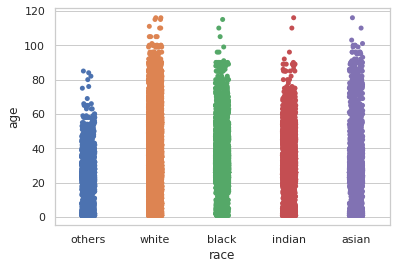

In [ ]:
sns.set(style ="whitegrid") 
_ = sns.stripplot(x='race',y='age',data=df)

# Not very useful :( , we only understand that not many elderly ppl (above 60) in others category are present 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


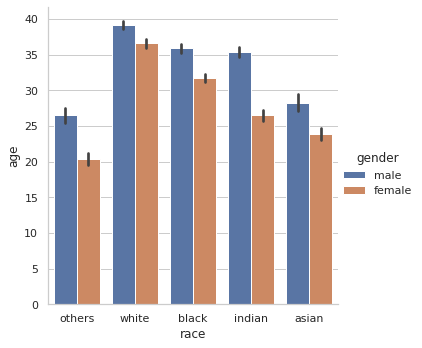

In [ ]:
sns.factorplot('race', 'age', 'gender', data=df,kind='bar');

# Gives the mean age of both genders of all races

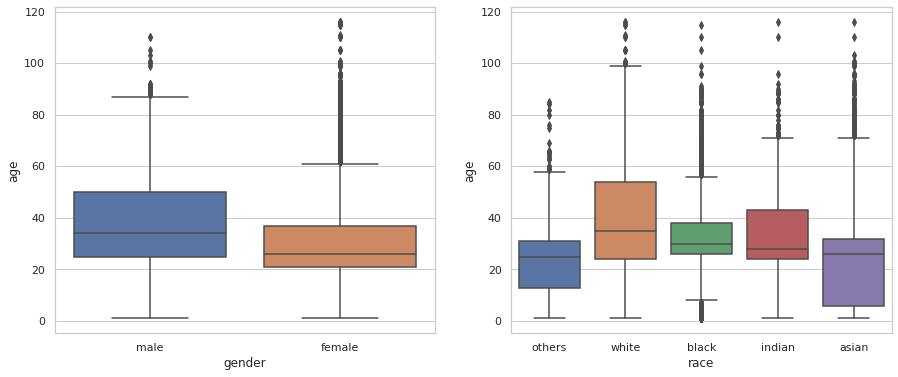

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

In [ ]:
df['age'] = df['age']//25

''' This basically makes 5 divisions in age-groups - 
1. 0-24
2. 25-49
3. 50-74
4. 75-99
5. 100-124 '''

In [ ]:
x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum()

print(x,' ',y,' ',z,' ',a,' ',b, ' ',c)


6903   11818   3988   967   32   0


In [ ]:
df.head()

,age,gender,race,file
0,0.0,male,others,/content/drive/My Drive/Colab Notebooks/Age an...
1,0.0,female,white,/content/drive/My Drive/Colab Notebooks/Age an...
2,0.0,male,others,/content/drive/My Drive/Colab Notebooks/Age an...
3,0.0,female,white,/content/drive/My Drive/Colab Notebooks/Age an...
4,0.0,male,others,/content/drive/My Drive/Colab Notebooks/Age an...


## Data Generator
In order to input our data to our Keras multi-output model, we have a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels (instead of just loading all the dataset into the memory at once, which might lead to an out of memory error).

In [ ]:
from keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx
            
def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.
    
    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):  # Used to generate a batch with images when training/validating our model.
    
    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)
            
            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,5))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
                
        if not is_training:
            break
            

## Model Architecture

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

import tensorflow as tf

def make_default_hidden_layers(inputs):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

def build_gender_branch(inputs):
  
    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
  
    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x)

    return x

def build_age_branch(inputs):   

    x = make_default_hidden_layers(inputs)
    
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)  

    return x


def assemble_model(width, height):
  
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, gender_branch], name="face_net")

    return model
    
model = assemble_model(198, 198)

Convolutional neural networks work on 2 assumptions -

1. Low level features are local
2. What's useful in one place will also be useful in other places.

Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand. In general, smaller filters are considered better than larger filter sizes. Also, usually -

* Number of filters tend to increase with depth of model (more representational capacity is required in the model)

* Size of filters is almost always odd. Like 3x3, 5x5
* Filter size tends to decrease with depth of the model (initial layers have larger receptive fields).

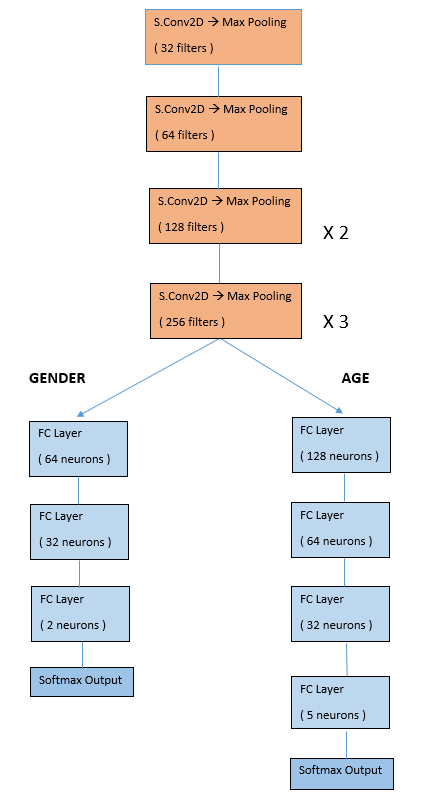

In [2]:
picture = "/content/drive/My Drive/classifiers.PNG"                                  
from IPython.display import Image
Image(picture, width=350)

# Model design flowchart

In [ ]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 198, 198, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_25 (SeparableC (None, 198, 198, 32) 155         input_3[0][0]                    
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 198, 198, 32) 0           separable_conv2d_25[0][0]        
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 66, 66, 32)   0           activation_35[0][0]              
___________________________________________________________________________________________

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

#  When training a neural network, the learning rate is often the most important 
# hyperparameter to tune. When training deep neural networks, it is often useful 
# to reduce learning rate as the training progresses.

# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)                                     # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'accuracy', 
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]

# It is this callback that allows a function to invoke during program execution.

 Keras does not touch class imbalance issues on its own.  If you aren't going to handle imbalance from the data directly, you should introduce an additional parameter in your loss function that understands the class distribution. In Keras, the param is called `class_weight`

Class weights, ensure that the unevenness in data distribution is sorted out.
Basically, **classes with less numbers are given more weight**, so that model doesn't get biased towards the more prevalent classes.

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.array([0,1,2,3,4]) ,np.array(df['age']))


class_weight1 = {'age_output': class_weight}

### Some key points to remember


*   **ModelCheckpoint** - ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. This is very essential as DL models can take upto days to train. By default - it's NULL.

    By keeping the filename constant throughout training, we ensure that only the best model weights remain in the file uptill the point we have trained.   
To load weights - `model.load_weights(filepath)`

---



*  **Fit function** -  In the latest version of TF - 2.2.0v (released May 2020), the *fit* function has replaced the *fit_generator* function present before.

---


*  **Validation while training** - All the VALIDATION things, in the *fit* function are related to data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data 

---

*   **Loss functions** ( `binary_crossentropy` vs `categorical_crossentropy`) -

  -- For `binary_crossentropy`, sigmoid activation, scalar target

  -- For `categorical_crossentropy`, softmax activation, one-hot encoded target

---

*  **LearningRateSchedular Callback** - The LearningRateScheduler callback allows us to define a function to call that takes the epoch number as an argument and returns the learning rate to use in optimizer. When used, the learning rate specified by optimizer is ignored.









In [ ]:
train_gen = generate_images(train_idx, is_training=True, batch_size=32)

# Since, train_idx is too large to fit inside RAM at once, we generate batches of size 32/64 from it (called train_gen))

valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/22
592/592 [==============================] - 200s 337ms/step - loss: 2.0457 - age_output_loss: 1.1166 - gender_output_loss: 0.5320 - age_output_accuracy: 0.5296 - gender_output_accuracy: 0.7298 - val_loss: 2.1632 - val_age_output_loss: 1.3199 - val_gender_output_loss: 0.4401 - val_age_output_accuracy: 0.4390 - val_gender_output_accuracy: 0.7865
Epoch 2/22
592/592 [==============================] - 192s 324ms/step - loss: 1.4360 - age_output_loss: 0.8870 - gender_output_loss: 0.3670 - age_output_accuracy: 0.6281 - gender_output_accuracy: 0.8369 - val_loss: 1.4478 - val_age_output_loss: 0.9380 - val_gender_output_loss: 0.3106 - val_age_output_accuracy: 0.6132 - val_gender_output_accuracy: 0.8585
Epoch 3/22
592/592 [==============================] - 194s 327ms/step - loss: 1.2849 - age_output_loss: 0.7804 - gender_output_loss: 0.3219 - age_output_accuracy: 0.6670 - gender_output_accuracy: 0.8596 - val_loss: 1.2353 - val_age_output_loss: 0.8277 - val_gender_output_loss: 0.3026 - v



---


Clearly, the performance of the model is saturating. I found the reason to be the diminutive learning rate after 45 epochs which becomes 0.0005, that is too low for the model to learn anything. *When the learning rate is too small, training is not only slower, but may become permanently stuck with a high training error.* This is precisely what seems to have happened above.

Hence, we train the model, by **re-establishing the learning rate** to a lower value than initialized before (as model would be now at the trough , looking for the minimum using Adam optimizer). I decided it to be 0.002 and again keep a drop every 12 epochs. Initializing the learning rate higher than 0.002, results in very volatile and fluctuating results, as the model keeps on oscillating about that minimum. 

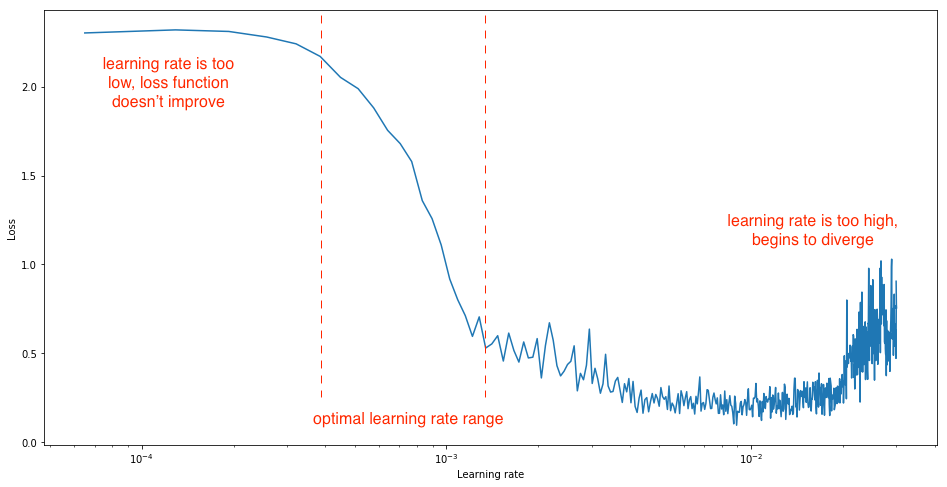

In [ ]:
picture = "/content/drive/My Drive/lr_finder.png"                                  
from IPython.display import Image
Image(picture, width=800)

In [ ]:
import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
	initial_lrate = 0.002
	drop = 0.5
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)
callbacks_list = [lrate]

history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



Epoch 1/22
592/592 [==============================] - 10910s 18s/step - loss: 0.6538 - age_output_loss: 0.4499 - gender_output_loss: 0.1399 - age_output_accuracy: 0.8294 - gender_output_accuracy: 0.9517 - val_loss: 0.3447 - val_age_output_loss: 0.3667 - val_gender_output_loss: 0.1035 - val_age_output_accuracy: 0.8575 - val_gender_output_accuracy: 0.9628
Epoch 2/22
592/592 [==============================] - 158s 268ms/step - loss: 0.5831 - age_output_loss: 0.4121 - gender_output_loss: 0.1203 - age_output_accuracy: 0.8385 - gender_output_accuracy: 0.9578 - val_loss: 0.4025 - val_age_output_loss: 0.3830 - val_gender_output_loss: 0.1111 - val_age_output_accuracy: 0.8499 - val_gender_output_accuracy: 0.9599
Epoch 3/22
592/592 [==============================] - 158s 267ms/step - loss: 0.5579 - age_output_loss: 0.3978 - gender_output_loss: 0.1109 - age_output_accuracy: 0.8471 - gender_output_accuracy: 0.9618 - val_loss: 0.5020 - val_age_output_loss: 0.3963 - val_gender_output_loss: 0.1199 - v

We see that the model has started overfitting. Validation loss for both age and gender is increasing, which a clear sign of overfitting. Hence, stop the training, else the model might lose its generalization ability.

I tried training further, and the accuracy was not able to increase. Hence, I conclude that the model has achieved saturation.

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/a_g_best')         # Saving the above run model. It has performed best till date.

new_model.save("/content/drive/My Drive/Colab Notebooks/a_g_best.h5")  # Converting to .h5 file for deployment


In [ ]:
from keras.models import load_model
new_model = load_model('/content/drive/My Drive/Colab Notebooks/a_g_best')

Using TensorFlow backend.


### The short answer to saving and loading - 

#### **Saving a Keras Model** -
`model = ...  # Get model (Sequential, Functional Model, or Model subclass)`

`model.save('path/to/location')`

This `save` function saves -


1.   The architecture of the model, allowing to re-create the model.
2.   The weights of the model.
3.   The training configuration (loss, optimizer).
4.   The state of the optimizer, allowing to resume training exactly where you left off.

Calling `save('my_model')` creates a SavedModel folder `my_model`, containing the following - `assets` , `saved_model.pb` &  `variables`. The model architecture, and training configuration (including the optimizer, losses, and metrics) are stored in `saved_model.pb`. The weights are saved in the `variables/` directory.

#### **Loading the model back** - 
`model = keras.models.load_model('path/to/location')`




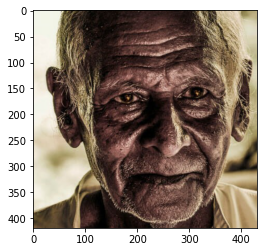

50-74 yrs old
Male


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

picture = "/content/drive/My Drive/old_man.jpg"                                     
age_pred, gender_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
max=-1
count=0

for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')
